In [17]:
%load_ext autoreload
%autoreload 1
%autosave 60

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


In [119]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm
from difflib import SequenceMatcher
from adjustText import adjust_text
import itertools
from sklearn.mixture import GaussianMixture

In [19]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")
sys.path.append("/u/davidm/DoubletDetection/")

In [20]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [48]:
sample = "Sample_N702_-_CTR1"
new_sample_name = "MCF7-labo-er1"
quant_params = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/forceCells-3000-noWh"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp779"
cell_line="MCF7"
cond = "ctrl"

In [95]:
def plot_errors_v1(connected_components, barcodes, weight_by_lib = True) :
    
    fig, ax = plt.subplots(figsize = (3.5,2.5))

    ind = np.arange(12) 
    error_pos = [{"A": 0, "T": 0, "G": 0, "C": 0} for _ in ind]

        
    for component in connected_components :
        
        if len(component) > 1 :
            
            n_reads = sc.obs[[(barcode in component) and (barcode in barcodes) for barcode in sc.obs_names]]["raw_cb_freq"].values
            nucleotides_per_position = np.array([list(c) for c in np.intersect1d(component, barcodes)]).T

            for i, (nts_pos,r) in enumerate(zip(nucleotides_per_position, np.repeat([n_reads], 12, axis=0))) :
                if len(np.unique(nts_pos)) > 1 :
                    for nt in error_pos[i].keys() :
                        if weight_by_lib :
                            error_pos[i][nt] += np.sum(r[nts_pos == nt])
                        else :
                            error_pos[i][nt] += 1

    
    
    counts = np.array([list(error_pos[i].values()) for i in ind])

    width = 0.35
    bottom = 0
    for c in np.array(counts).T :
        ax.bar(ind, c, width = 0.25, bottom = bottom)
        bottom += c

    ax.legend(labels = error_pos[0].keys())
    plt.xticks(ind, labels = ind+1)
    plt.show()

In [96]:
def plot_errors(errors_dict, barcodes, weight_by_lib = True) :
    nucleotides = ["A","T","G","C"]
    substitutions = {f"{pos}-{nt1}": {nt2 : 0 for nt2 in nucleotides} for pos in np.arange(1,13) for nt1 in nucleotides}


    for barcode1 in errors_dict.keys() :
        for barcode2 in errors_dict[barcode1] :
            if barcode2 not in barcodes :
                continue
            pos = [i for i in range(len(barcode1)) if barcode1[i] != barcode2[i]][0]
            nt1 = list(barcode1)[pos]
            nt2 = list(barcode2)[pos]
            if weight_by_lib :
                substitutions[f"{pos+1}-{nt1}"][nt2] += sc.obs["raw_cb_freq"].loc[barcode2]
            else :
                substitutions[f"{pos+1}-{nt1}"][nt2] += 1
    
    counts = np.array([list(list(substitutions.values())[i].values()) for i in np.arange(48)])
    fig, ax = plt.subplots(figsize=(5.5,2.5))
    bottom = 0
    for c in counts.T :
        ax.bar(np.arange(48), c, width = 0.7, bottom = bottom)
        bottom += c

    ax.legend(labels = nucleotides)
    plt.xticks(np.arange(48), labels = substitutions.keys(), rotation = 90)
    plt.ylim(0,np.max(bottom)+np.max(bottom)/30)
    plt.show()

In [43]:
def DFS(neighbors_mtx, component, barcode, visited):

    visited[barcode] = True
    component.append(barcode)
    
    neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
    for neighbor in neighbors :
        if visited[neighbor][0] == False:
            component = DFS(neighbors_mtx, component, neighbor, visited)
    return component


def connectedComponents(neighbors_mtx) :
    
    barcodes = neighbors_mtx.index.values
    visited = pd.DataFrame([np.repeat(False, len(barcodes))], columns = barcodes, index = ["visited"])
    all_components = []

    for barcode in barcodes :
        if visited[barcode][0] == False:
            component = []
            all_components.append(DFS(neighbors_mtx, component, barcode, visited))
    
    i = np.argsort([len(c) for c in all_components])[::-1]
    
    return np.array(all_components, dtype = object)[i]

In [115]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    error_dict = {}

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    
    for component in all_components :
                
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel(), neighbors_mtx[component].sum(0)]).T,\
                                      columns = ["total_UMIs", "total_neighbors"], index = component)
            barcode = sorting_df.sort_values(by=["total_neighbors", "total_UMIs"], ascending=False).index.values[0]

            whitelist.append(barcode)
#             neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
#             error_dict[barcode] = neighbors
            error_dict[barcode] = np.setdiff1d(component, [barcode])

    
    return all_components, error_dict, whitelist

In [215]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    error_dict = {}

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    
    for component in all_components :
                
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel(), neighbors_mtx[component].sum(0)]).T,\
                                      columns = ["total_UMIs", "total_neighbors"], index = component)
            sorted_comp = sorting_df.sort_values(by=["total_UMIs"], ascending=False).index.values
            barcode = sorted_comp[0]
            whitelist.append(barcode)
            neighbors = neighbors_mtx.loc[barcode][sorted_comp]
            neighbors = neighbors.index.values[neighbors == 1]
            error_dict[barcode] = neighbors
#             error_dict[barcode] = np.setdiff1d(component, [barcode])

    
    return all_components, error_dict, whitelist

In [116]:
def get_intended_barcodes(errors_dict, barcodes) :
    
    intended_list = []
    errors_list = []
    for intended, erroneous in errors_dict.items(): 
        for barcode in erroneous :
            if barcode in barcodes :
                errors_list.append(barcode)
                intended_list.append(intended)
    
    return np.array(intended_list), np.array(errors_list)

In [218]:
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker

class SquareScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square scale.
    """
 
    name = 'square'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax
 
    class SquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return np.array(a)**2
 
        def inverted(self):
            return SquareScale.InvertedSquareTransform()
 
    class InvertedSquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return np.array(a)
 
        def inverted(self):
            return SquareScale.SquareTransform()
 
    def get_transform(self):
        return self.SquareTransform()

mscale.register_scale(SquareScale)

### Plotting parameters

In [22]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 6

### Alevin 

In [67]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
# sc._inplace_subset_obs(np.argsort(sc.obs["raw_cb_freq"].values)[::-1][:3000])
sc.obs_names = sc.obs["CB"]

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [24]:
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())

# libs = sc.obs["total_UMIs"].values * 0.8
# scanpy.pp.downsample_counts(adata=sc, counts_per_cell=libs)

In [68]:
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "conditions", samples_annot = cond)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "cell_lines", samples_annot = cell_line)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "source", samples_annot = "labo")
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "samples", samples_annot = new_sample_name, ow = True)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel(), ow=True)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())

rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr", ow=True)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac")

Annotating total_UMIs...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...


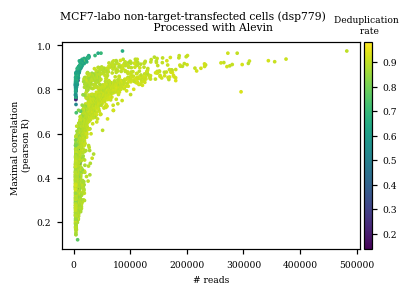

In [64]:
rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["DedupRate"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-target-transfected cells (dsp779)           \n Processed with Alevin",\
                        color_title = "Deduplication \n rate",\
                        save = f"./figs/{cond}-reads-max-corr.svg")

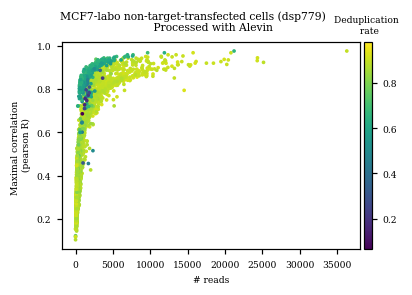

In [114]:
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["DedupRate"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-target-transfected cells (dsp779)           \n Processed with Alevin",\
                        color_title = "Deduplication \n rate",\
                        save = f"./figs/{cond}-reads-max-corr.svg")

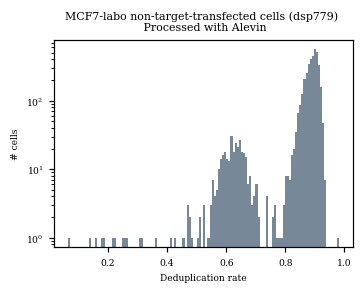

In [208]:
plt.subplots(figsize=(3.5,2.5))

plt.hist(sc.obs["DedupRate"], bins = 130, color = "lightslategray");
plt.xlabel("Deduplication rate");
plt.ylabel("# cells");
plt.title("MCF7-labo non-target-transfected cells (dsp779) \n Processed with Alevin")
plt.savefig(f"./figs/distrib_dedup_{cond}.svg")
plt.yscale('log')

In [66]:
barcodes = sc.obs["CB"].values

n_neighbors = [np.sum([hammingDist(cb1, cb2) == 1 for cb2 in barcodes]) for cb1 in barcodes]
pd.DataFrame(np.unique(n_neighbors, return_counts=True))

,0,1,2,3,4,5
0,0,1,2,3,4,5
1,1443,523,122,890,21,1


In [72]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    error_dict = {}

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    # n_components, labels = connected_components(csgraph = csr_matrix(neighbors_mtx), directed=False, return_labels=True)
    
    for component in all_components :
    #for component_idx in range(n_components) :
        
        #component = barcodes[labels == component_idx]
        
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            absorbed = set([])        
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel(), neighbors_mtx[component].sum(0)]).T,\
                                      columns = ["total_UMIs", "total_neighbors"], index = component)
            sorted_barcodes = sorting_df.sort_values(by=["total_neighbors", "total_UMIs"], ascending=False).index.values

            for barcode in sorted_barcodes :
                neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
                whitelist.append(barcode)
                error_dict[barcode] = list(neighbors[[n not in absorbed for n in neighbors]])
                absorbed.add(barcode)
                absorbed.update(list(neighbors))
                if len(absorbed) == len(component) :
                    break
    
    return all_components, error_dict, whitelist

In [216]:
libs = sc.obs["raw_cb_freq"]

connected_components, errors_dict, whitelist = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2627 barcodes in the new whitelist


In [220]:
gm = GaussianMixture(2, covariance_type="full")
# clusters_3 = gm.fit_predict((sc.obs["DedupRate"].values).reshape(-1,1)).astype(object)
errors = np.concatenate(list(errors_dict.values()))
# X = np.array([sc.obs["DedupRate"].loc[errors], sc.obs["max_corr"].loc[errors],np.log1p(sc.obs["total_UMIs"].loc[errors])]).T

X = np.array([sc.obs["DedupRate"].loc[errors]]).T

clusters = gm.fit_predict(X).astype(object)

means = pd.DataFrame({"cluster" : clusters, "dedup" : sc.obs["DedupRate"].loc[errors]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)


for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters[clusters == cl] = str(new_cl)
    
    
# sc.obs["cluster_3"] = clusters_3
sc.obs["clusters"] = np.repeat(None, sc.X.shape[0])
# sc.obs["AT"] = np.repeat(False, sc.X.shape[0])
for barcode, cl in zip(errors, clusters) :
    sc.obs["clusters"].loc[barcode] = str(cl)

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


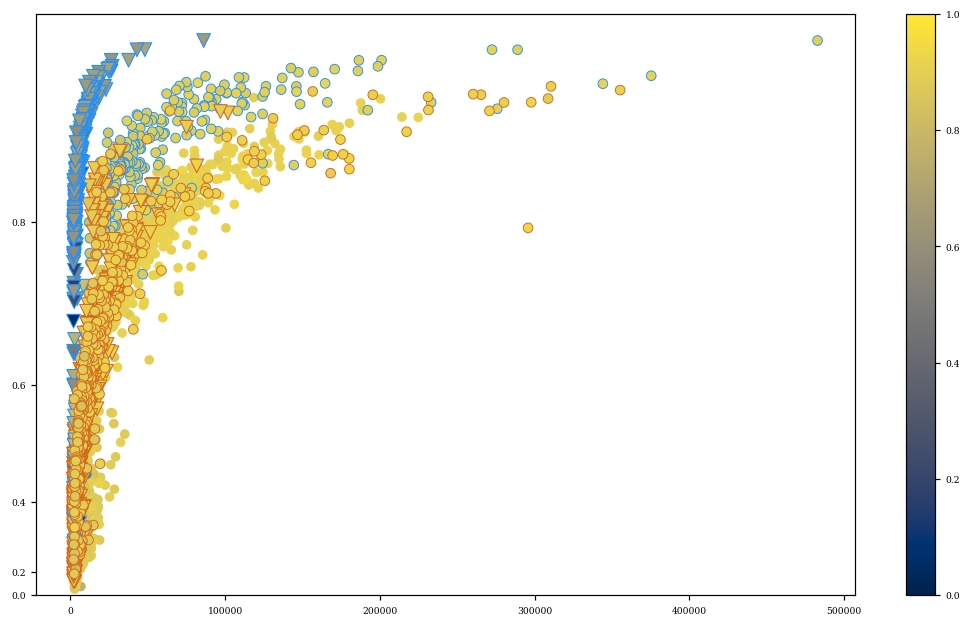

In [222]:
fig, ax = plt.subplots(figsize=(12,7))


errors = np.concatenate(list(errors_dict.values()))

ax.scatter(sc.obs["raw_cb_freq"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           sc.obs["max_corr"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], s = 40, \
           c = sc.obs["DedupRate"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           vmin = 0, vmax = 1, cmap = "cividis", marker = 'o', linewidths=0, edgecolors='black', zorder = 1)
ax.scatter(sc.obs["raw_cb_freq"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb \
        in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "0"] for cb \
        in sc.obs_names]], s = 40, c = sc.obs["DedupRate"].values[[cb in errors_dict.keys() and errors_dict[cb][0] \
        in sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], vmin = 0, vmax = 1, cmap = "cividis", \
        marker = 'o', linewidths=0.6, edgecolors='dodgerblue', zorder = 2)
ax.scatter(sc.obs["raw_cb_freq"].values[sc.obs["clusters"] == "1"], sc.obs["max_corr"].values[sc.obs["clusters"] == "1"], \
        s = 80, c = sc.obs["DedupRate"].values[sc.obs["clusters"] == "1"], vmin = 0, vmax = 1, marker = 'v', linewidths=0.7, \
        cmap = "cividis", edgecolors='chocolate', zorder = 3)
scatt = ax.scatter(sc.obs["raw_cb_freq"].values[sc.obs["clusters"] == "0"], sc.obs["max_corr"].values[sc.obs["clusters"] \
        == "0"], s = 80, c = sc.obs["DedupRate"].values[sc.obs["clusters"] == "0"], vmin = 0, vmax = 1, marker = 'v', \
        linewidths=0.7,  cmap = "cividis", edgecolors='dodgerblue', zorder = 4)
ax.scatter(sc.obs["raw_cb_freq"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] \
        == "1"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], s = 40, c = sc.obs["DedupRate"].values[[cb \
        in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], \
        vmin = 0, vmax = 1, cmap = "cividis", marker = 'o', linewidths=0.6, edgecolors='chocolate', zorder = 5)
fig.colorbar(scatt)

# i = 0
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] > 0.8 and sc.obs["clusters"].loc[barcode1] == "1": # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 ax.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 6, alpha = 0.5)
#                 i += 1
                
# ax.set_xscale("squareroot")
ax.set_yscale("square")

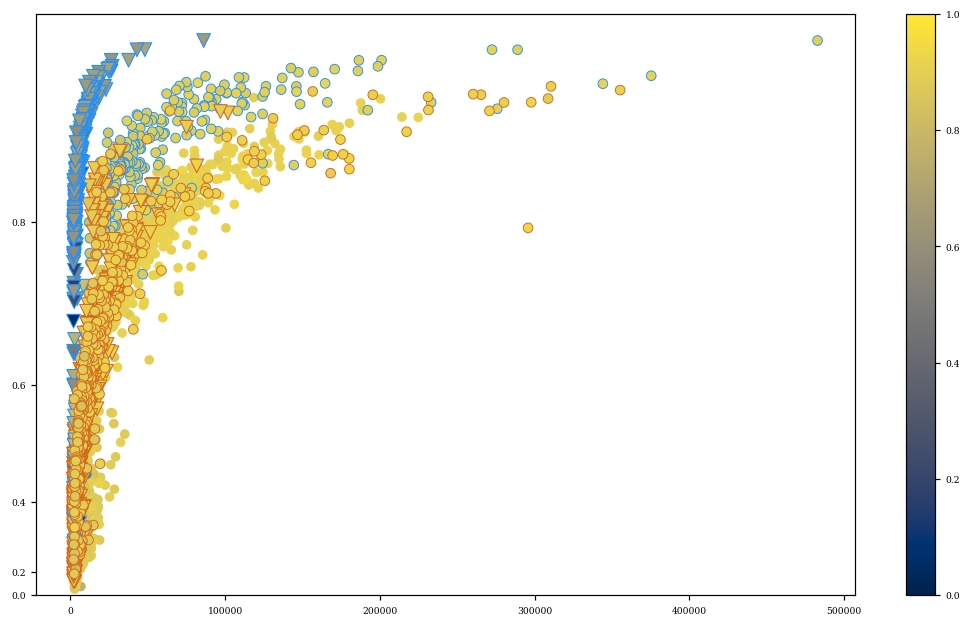

In [227]:
fig, ax = plt.subplots(figsize=(12,7))


errors = np.concatenate(list(errors_dict.values()))
# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"

vmin = 0
vmax = 1

ax.scatter(sc.obs["raw_cb_freq"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           sc.obs["max_corr"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], s = 40, \
           c = sc.obs[color].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           vmin = vmin, vmax = vmax, cmap = "cividis", marker = 'o', linewidths=0, edgecolors='black', zorder = 1)
ax.scatter(sc.obs["raw_cb_freq"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb \
        in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "0"] for cb \
        in sc.obs_names]], s = 40, c = sc.obs[color].values[[cb in errors_dict.keys() and errors_dict[cb][0] \
        in sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], vmin = vmin, vmax = vmax, cmap = "cividis", \
        marker = 'o', linewidths=0.6, edgecolors='dodgerblue', zorder = 2)
ax.scatter(sc.obs["raw_cb_freq"].values[sc.obs["clusters"] == "1"], sc.obs["max_corr"].values[sc.obs["clusters"] == "1"], \
        s = 80, c = sc.obs[color].values[sc.obs["clusters"] == "1"], vmin = vmin, vmax = vmax, marker = 'v', linewidths=0.7, \
        cmap = "cividis", edgecolors='chocolate', zorder = 3)
scatt = ax.scatter(sc.obs["raw_cb_freq"].values[sc.obs["clusters"] == "0"], sc.obs["max_corr"].values[sc.obs["clusters"] \
        == "0"], s = 80, c = sc.obs[color].values[sc.obs["clusters"] == "0"], vmin = vmin, vmax = vmax, marker = 'v', \
        linewidths=0.7,  cmap = "cividis", edgecolors='dodgerblue', zorder = 4)
ax.scatter(sc.obs["raw_cb_freq"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] \
        == "1"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], s = 40, c = sc.obs[color].values[[cb \
        in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], \
        vmin = vmin, vmax = vmax, cmap = "cividis", marker = 'o', linewidths=0.6, edgecolors='chocolate', zorder = 5)
fig.colorbar(scatt)


# i = 0
# cbs_2 = []
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] : #and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] < 0.85 and sc.obs["clusters"].loc[barcode1] == "1": # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 cbs_2.append(barcode1)
#                 x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 ax.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 6, alpha = 0.5)
#                 i += 1
                
# ax.set_xscale("squareroot")
ax.set_yscale("square")

In [77]:
originals_low_dedup = []
errors_low_dedup = []
originals_normal_dedup = []
errors_normal_dedup = []

for original in errors_dict.keys():
    for error in errors_dict[original] :
        if sc.obs["DedupRate"][sc.obs["CB"] == error][0] < 0.7 :
            originals_low_dedup.append(original)
            errors_low_dedup.append(error)
        else :
            originals_normal_dedup.append(original)
            errors_normal_dedup.append(error)
            

no_error = np.concatenate(connected_components[[len(c)==1 for c in connected_components]])

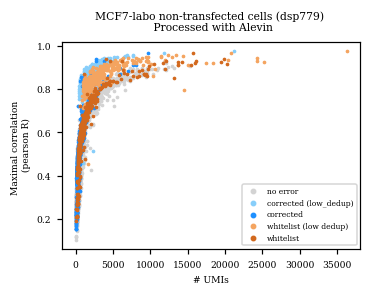

In [78]:
select = []

for barcode in sc.obs["CB"] :
    if barcode in no_error :
        select.append("no error")
    elif barcode in errors_low_dedup :
        select.append("corrected (low_dedup)")
    elif barcode in originals_low_dedup :
        select.append("whitelist (low dedup)")
    elif barcode in errors_normal_dedup :
        select.append("corrected")
    elif barcode in originals_normal_dedup :
        select.append("whitelist")

sc.obs["select"] = np.array(select, dtype=str)

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"corrected (low_dedup)" : "lightskyblue", "whitelist (low dedup)": "sandybrown",\
                                   "corrected" : "dodgerblue", "whitelist": "chocolate", "no error":"lightgray"},\
                        order_color = ["no error",  "corrected (low_dedup)", "corrected", "whitelist (low dedup)", "whitelist"],\
                        save= "./figs/all_errors.pdf"
)

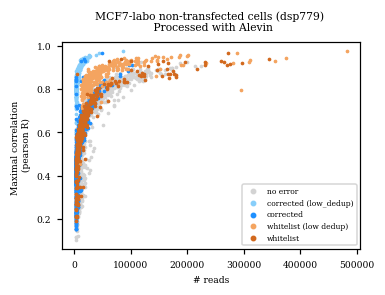

In [79]:
rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"corrected (low_dedup)" : "lightskyblue", "whitelist (low dedup)": "sandybrown",\
                                   "corrected" : "dodgerblue", "whitelist": "chocolate", "no error":"lightgray"},\
                        order_color = ["no error",  "corrected (low_dedup)", "corrected", "whitelist (low dedup)", "whitelist"],\
                        save= "./figs/all_errors.pdf"
)
# plt.xlim(0,160000)

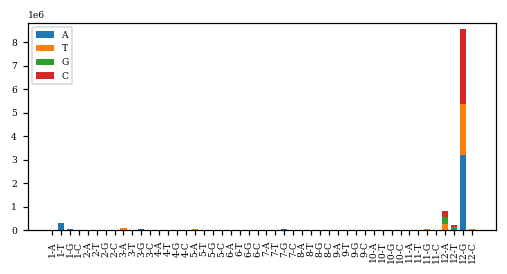

In [193]:
plot_errors(errors_dict, errors_normal_dedup)

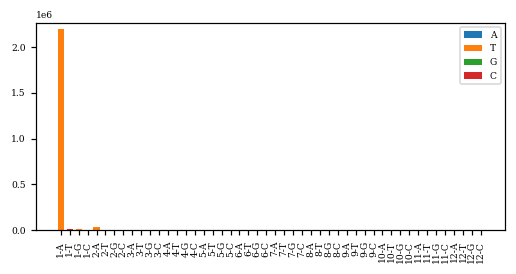

In [194]:
plot_errors(errors_dict, errors_mid_dedup)

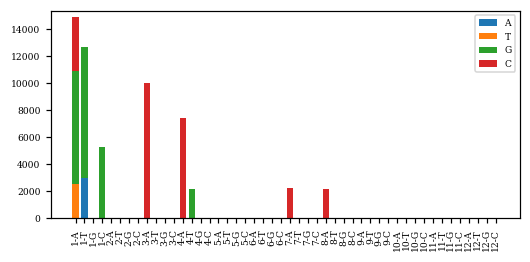

In [195]:
plot_errors(errors_dict, errors_low_dedup)

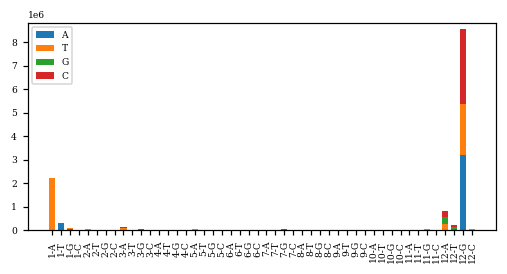

In [196]:
plot_errors(errors_dict, sc.obs_names)

In [117]:
libs = sc.obs["raw_cb_freq"]

connected_components, errors_dict, whitelist = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2627 barcodes in the new whitelist


In [209]:
from sklearn.cluster import KMeans

gm = KMeans(3)
clusters_3 = gm.fit_predict((sc.obs["DedupRate"].values).reshape(-1,1)).astype(object)

means = pd.DataFrame({"cluster" : clusters_3, "dedup" : sc.obs["DedupRate"]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)

for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters_3[clusters_3 == cl] = str(new_cl)

sc.obs["cluster_3"] = clusters_3

In [212]:
best_s = -np.infty
for i in range(100) :
    cl = gm.fit_predict(sc.obs["DedupRate"].values.reshape(-1,1))
#     ll = gm.score(sc.obs["DedupRate"].values.reshape(-1,1))
    s = silhouette_score(sc.obs["DedupRate"].values.reshape(-1,1), cl)
    if s > best_s :
        best_gm = gm


clusters_3 = best_gm.predict(sc.obs["DedupRate"].values.reshape(-1,1)).astype(object)

means = pd.DataFrame({"cluster" : clusters_3, "dedup" : sc.obs["DedupRate"]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)

for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters_3[clusters_3 == cl] = str(new_cl)

sc.obs["cluster_3"] = clusters_3

In [198]:
errors_low_dedup = []
errors_mid_dedup = []
errors_normal_dedup = []

for original in errors_dict.keys():
    for error in errors_dict[original] :
        if sc.obs["cluster_3"].loc[error] == '0':
            errors_low_dedup.append(error)
        elif sc.obs["cluster_3"].loc[error] == '1':
            errors_mid_dedup.append(error)
        else :
            errors_normal_dedup.append(error)
            

no_error = np.concatenate(connected_components[[len(c)==1 for c in connected_components]])

In [122]:
import pandas
import ast
sample = "Sample_N702_-_CTR1"
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pandas.read_csv(f"{project_path}/raw-fastqs/{sample}/new_umis.csv")

In [ ]:
low_dedup_shared_umis = []
mid_dedup_shared_umis = []
normal_dedup_shared_umis = []
random_shared_umis = []


for o,e in zip(get_intended_barcodes(errors_dict, errors_low_dedup)[0], get_intended_barcodes(errors_dict, errors_low_dedup)[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_e) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    low_dedup_shared_umis.append(shared_umis/n_umis)

for o,e in zip(get_intended_barcodes(errors_dict, errors_mid_dedup)[0], get_intended_barcodes(errors_dict, errors_mid_dedup)[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_e) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    mid_dedup_shared_umis.append(shared_umis/n_umis)
    
for o,e in zip(get_intended_barcodes(errors_dict, errors_normal_dedup)[0], get_intended_barcodes(errors_dict, errors_normal_dedup)[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_e) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    normal_dedup_shared_umis.append(shared_umis/n_umis)
    
for i in range(len(errors_normal_dedup)):
    cb1,cb2 = np.random.choice(no_error, 2, replace = False)
    umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
    umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_cb1) #+ len(umis_cb2)
    shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
    random_shared_umis.append(shared_umis/n_umis)

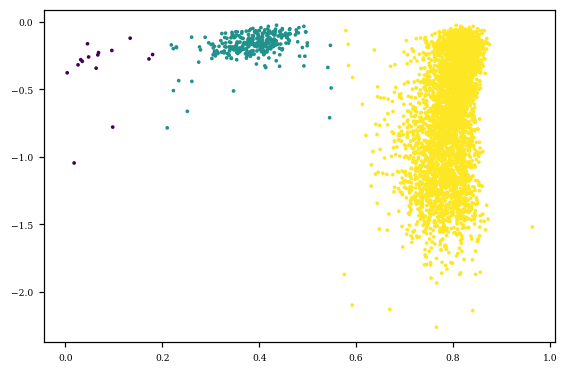

In [214]:
plt.scatter(sc.obs["DedupRate"]**2, np.log(sc.obs["max_corr"]), s = 2, c = sc.obs["cluster_3"].astype(int))

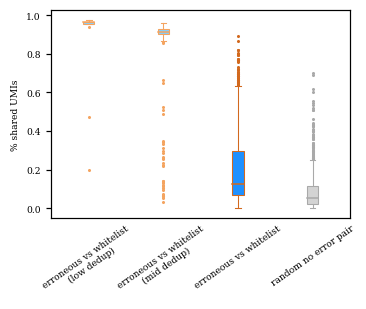

In [200]:
_, ax = plt.subplots(figsize=(3.5, 2.5))



bp = plt.boxplot(low_dedup_shared_umis, positions = [0], patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'color' : 'sandybrown', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 capprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 medianprops = {'color' : 'sandybrown', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'sandybrown', 'markeredgecolor':'sandybrown'})


bp = plt.boxplot(mid_dedup_shared_umis, positions = [1], patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'color' : 'sandybrown', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 capprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 medianprops = {'color' : 'sandybrown', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'sandybrown', 'markeredgecolor':'sandybrown'})

bp = plt.boxplot(normal_dedup_shared_umis, positions = [2], patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'color' : 'chocolate', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 capprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 medianprops = {'color' : 'chocolate', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'chocolate', 'markeredgecolor':'chocolate'})

bp = plt.boxplot(random_shared_umis, positions = [3], patch_artist = True,\
                 boxprops={'facecolor': 'lightgray', 'color' : 'darkgray', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'darkgray'},\
                 capprops = {'linewidth': 0.7, 'color':'darkgray'},\
                 medianprops = {'color' : 'darkgray', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'darkgray', 'markeredgecolor':'darkgray'})

plt.xticks(np.arange(0,4), labels = ["erroneous vs whitelist\n(low dedup)", "erroneous vs whitelist\n(mid dedup)", "erroneous vs whitelist", "random no error pair"])
ax.tick_params(axis='x', rotation = 35, length = 0)

plt.ylabel("% shared UMIs")
plt.savefig("./figs/shared_umis.pdf")

In [16]:
%%bash
tar czf ./figs.tar.gz ./figs/*.svg